In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font',size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings('ignore')

In [2]:
path='./'

trn_click=pd.read_csv(path+'train_click_log.csv') # 训练集
item_df=pd.read_csv(path+'articles.csv') # 文章信息
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
item_emb_df=pd.read_csv(path+'articles_emb.csv') # 文章emb

tst_click=pd.read_csv(path+'testA_click_log.csv') # 测试集

In [3]:
trn_click['rank']=trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int) # 根据每个用户的点击时间戳，对每个用户的数据进行排序
tst_click['rank']=tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int) # 对测试集进行相同的操作

In [4]:
trn_click['click_cnts']=trn_click.groupby(['user_id'])['click_timestamp'].transform('count') # transform()是一个多功能的函数，可以进行特征计算，transform('count')为计数
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

In [5]:
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40


In [6]:
trn_click=trn_click.merge(item_df,how='left',on=['click_article_id']) # item_df:文章信息，articles.csv
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


In [7]:
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
user_id                1112623 non-null int64
click_article_id       1112623 non-null int64
click_timestamp        1112623 non-null int64
click_environment      1112623 non-null int64
click_deviceGroup      1112623 non-null int64
click_os               1112623 non-null int64
click_country          1112623 non-null int64
click_region           1112623 non-null int64
click_referrer_type    1112623 non-null int64
rank                   1112623 non-null int64
click_cnts             1112623 non-null int64
category_id            1112623 non-null int64
created_at_ts          1112623 non-null int64
words_count            1112623 non-null int64
dtypes: int64(14)
memory usage: 127.3 MB


In [8]:
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [9]:
trn_click.user_id.nunique() # nunique():返回去重后的数量

200000

In [10]:
trn_click.groupby('user_id')['click_article_id'].count()

user_id
0          2
1          2
2          2
3          2
4          2
5          2
6          2
7          2
8          2
9          3
10         2
11         2
12         2
13         2
14         2
15         3
16         2
17         3
18         2
19         2
20         2
21         2
22         2
23         2
24         2
25         2
26         3
27         2
28         2
29         2
          ..
199970    11
199971     2
199972     5
199973     3
199974    34
199975    19
199976    14
199977     9
199978     6
199979    22
199980    15
199981    95
199982    23
199983     2
199984     9
199985    15
199986    14
199987    12
199988     2
199989    48
199990     5
199991     9
199992    36
199993    14
199994    22
199995     7
199996    13
199997     2
199998    40
199999    11
Name: click_article_id, Length: 200000, dtype: int64

In [11]:
trn_click.groupby('user_id')['click_article_id'].count().min()

2

<Figure size 432x288 with 0 Axes>

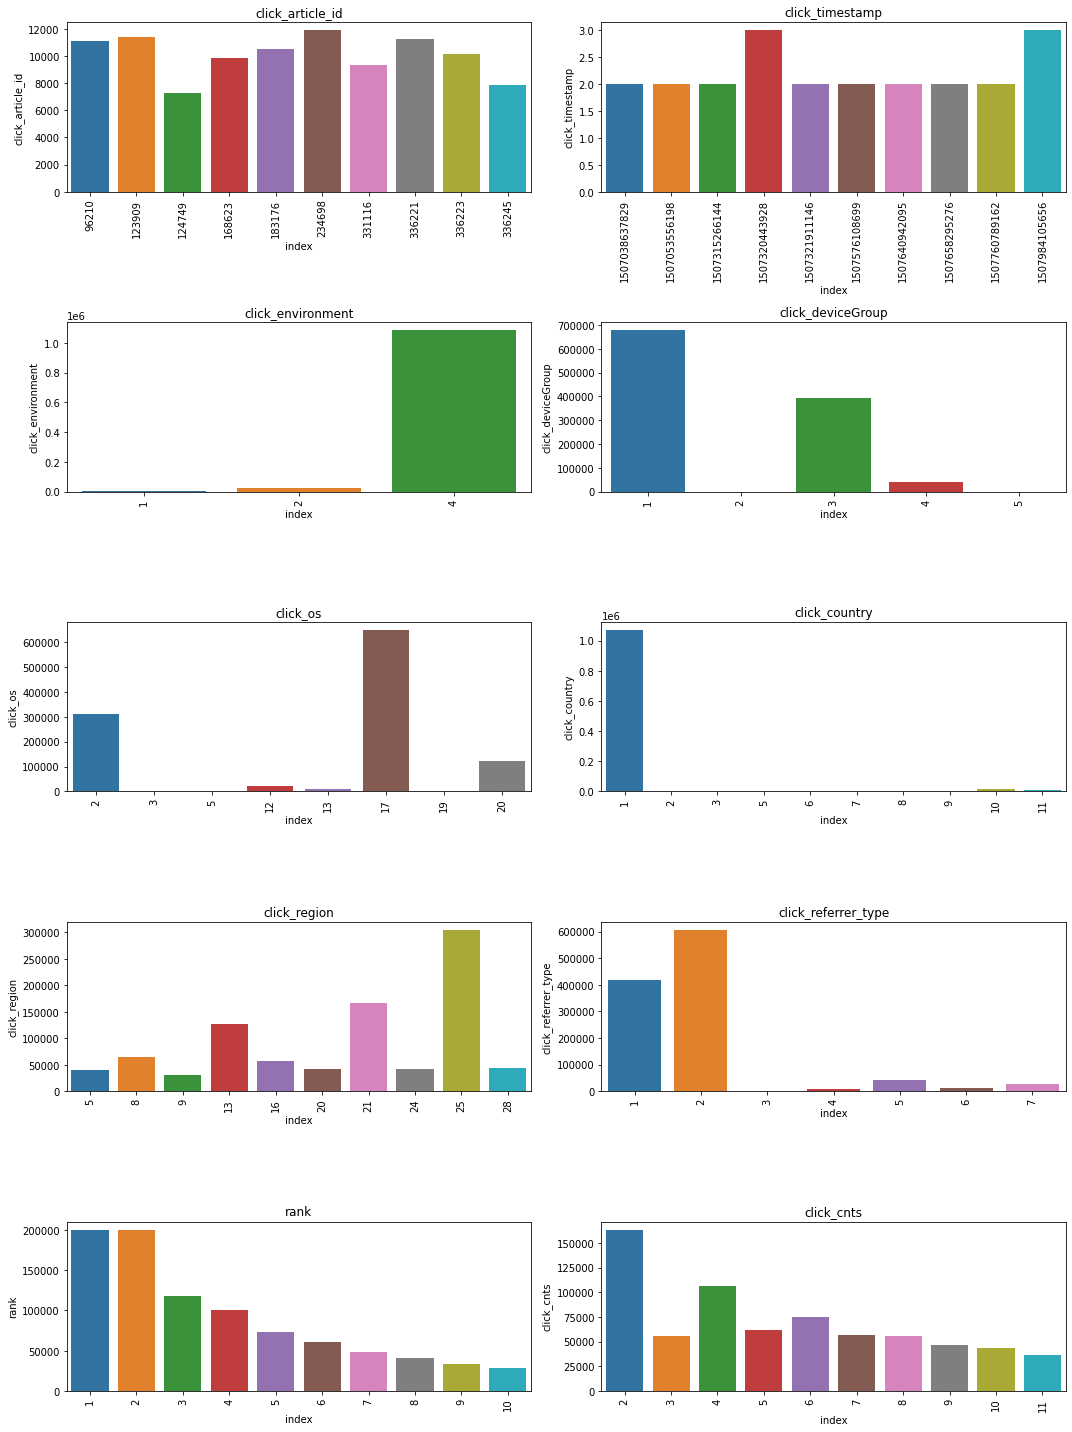

In [12]:
plt.figure()
plt.figure(figsize=(15,20))
i=1
for col in ['click_article_id','click_timestamp', 'click_environment', 'click_deviceGroup', 
            'click_os', 'click_country','click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs=plt.subplot(5,2,i)
    i+=1
    v=trn_click[col].value_counts().reset_index()[:10] # 对每列数据的值进行计数并排序，取前十个
    fig=sns.barplot(x=v['index'],y=v[col]) # 绘制条形图
    for item in fig.get_xticklabels():
        item.set_rotation(90) # 将X轴的标签旋转90°
    plt.title(col)
plt.tight_layout()
plt.show()

In [13]:
trn_click['click_article_id'].value_counts().reset_index()[:10]

,index,click_article_id
0,234698,11886
1,123909,11438
2,336221,11290
3,96210,11146
4,183176,10487
5,336223,10186
6,168623,9882
7,331116,9369
8,336245,7851
9,124749,7264


In [14]:
trn_click['click_environment'].value_counts()

4    1084627
2      25894
1       2102
Name: click_environment, dtype: int64

In [15]:
trn_click['click_deviceGroup'].value_counts()

1    678187
3    395558
4     38731
5       141
2         6
Name: click_deviceGroup, dtype: int64

In [16]:
tst_click=tst_click.merge(item_df,how='left',on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [17]:
tst_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


In [18]:
tst_click.user_id.nunique()

50000

In [19]:
tst_click.groupby('user_id')['click_article_id'].count().min()

1

In [20]:
item_df.head().append(item_df.tail())

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


In [21]:
item_df['words_count'].value_counts()

176     3485
182     3480
179     3463
178     3458
174     3456
183     3432
184     3427
173     3414
180     3403
177     3391
170     3387
187     3355
169     3352
185     3348
175     3346
181     3330
186     3328
189     3327
171     3327
172     3322
165     3308
188     3288
167     3269
190     3261
192     3257
168     3248
193     3225
166     3199
191     3182
194     3164
        ... 
601        1
857        1
1977       1
1626       1
697        1
1720       1
696        1
706        1
592        1
1605       1
586        1
582        1
1606       1
972        1
716        1
584        1
1608       1
715        1
841        1
968        1
964        1
587        1
1099       1
1355       1
711        1
845        1
710        1
965        1
847        1
1535       1
Name: words_count, Length: 866, dtype: int64

In [22]:
item_df['category_id'].nunique()

461

<AxesSubplot:>

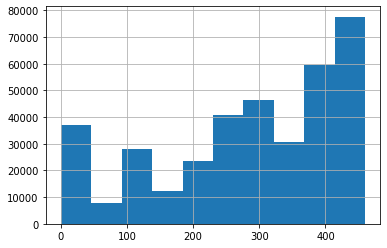

In [23]:
item_df['category_id'].hist()

In [24]:
item_df.shape

(364047, 4)

In [25]:
item_emb_df.head()

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [26]:
item_emb_df.shape

(364047, 251)

In [27]:
user_click_merge=trn_click.append(tst_click)

In [28]:
user_click_count=user_click_merge.groupby(['user_id','click_article_id'])['click_timestamp'].agg({'count'}).reset_index()

1. agg()：
调用时要指定字段，apply默认传入整个Dataframe

2. apply():
参数可以是自定义函数，包括简单的求和函数以及复制的特征间的差值函数等。apply不能直接使用python的内置函数，比如sum、max、min。

2. transform():
参数不能是自定义的特征交互函数，因为transform是针对每一元素(即每一列特征操作)进行计算。使用transform要注意：

    - 它只能对每一列进行计算，所以在groupby之后，transform之前是要指定操作的列，这点与apply有很大的不同
    - 由于是对每一列进行计算，所以方法通用性性比apply就局限了很多，例如，只能求列的最大值，最小值，均值，方差，分箱等操作。

**处理效率上：**

agg()函数+内置函数是计算速度最快的，其次是transform()+内置方法。

agg()或者apply()+自定义函数的处理速度差不多，而这里特别要注意transform()+自定义函数计算速度是最慢的，尽量避免使用。

In [29]:
user_click_count[:10]

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1
5,2,168401,1
6,3,36162,1
7,3,50644,1
8,4,39894,1
9,4,42567,1


In [30]:
user_click_count[user_click_count['count']>7]

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [31]:
user_click_count['count'].unique()

array([ 1,  2,  4,  3,  6,  5, 10,  7, 13])

In [32]:
user_click_count.loc[:,'count'].value_counts() # loc:按照标签取数据

1     1605541
2       11621
3         422
4          77
5          26
6          12
10          4
7           3
13          1
Name: count, dtype: int64

In [33]:
def plot_envs(df,cols,r,c):
    plt.figure()
    plt.figure(figsize=(10,5))
    i=1
    for col in cols:
        plt.subplot(r,c,i)
        i+=1
        v=df[col].value_counts().reset_index()
        fig=sns.barplot(x=v['index'],y=v[col])
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

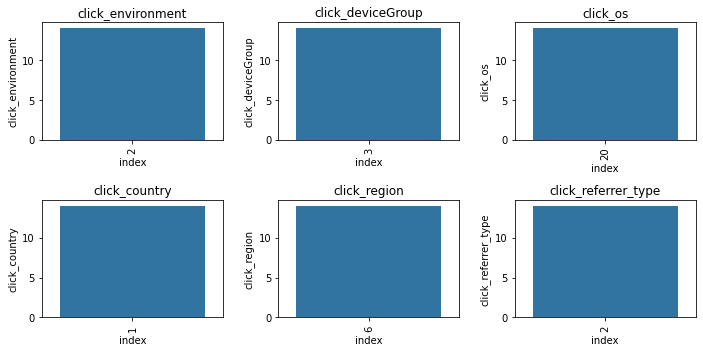

<Figure size 432x288 with 0 Axes>

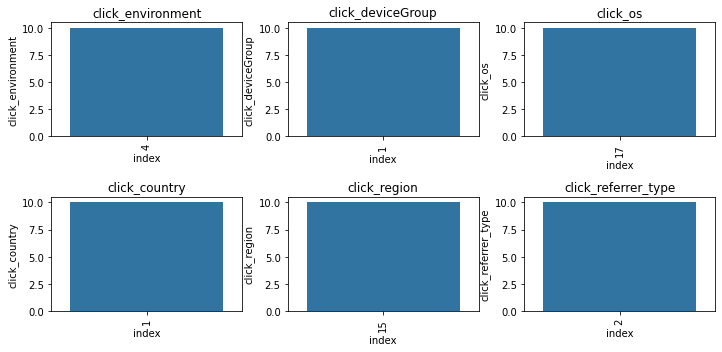

<Figure size 432x288 with 0 Axes>

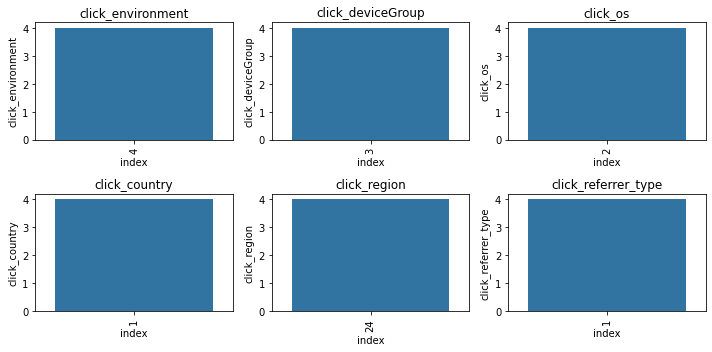

<Figure size 432x288 with 0 Axes>

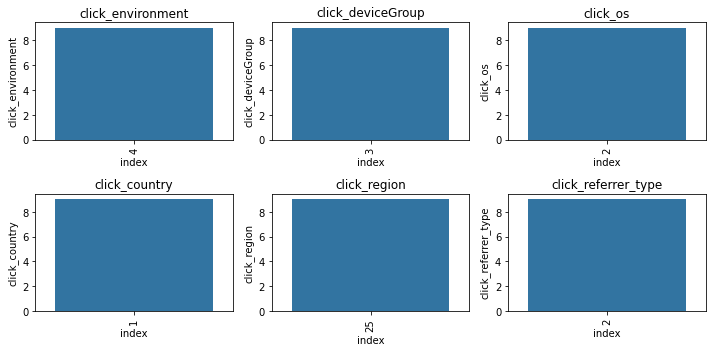

<Figure size 432x288 with 0 Axes>

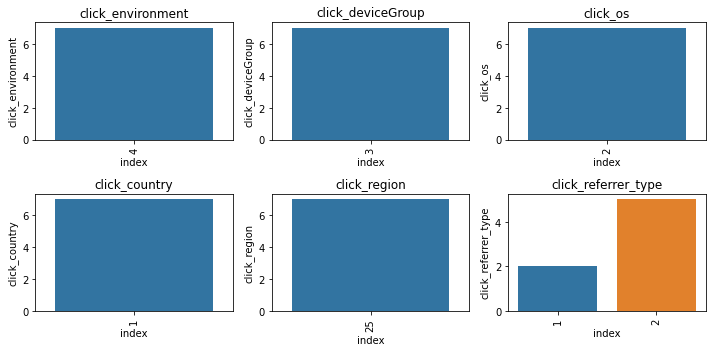

<Figure size 432x288 with 0 Axes>

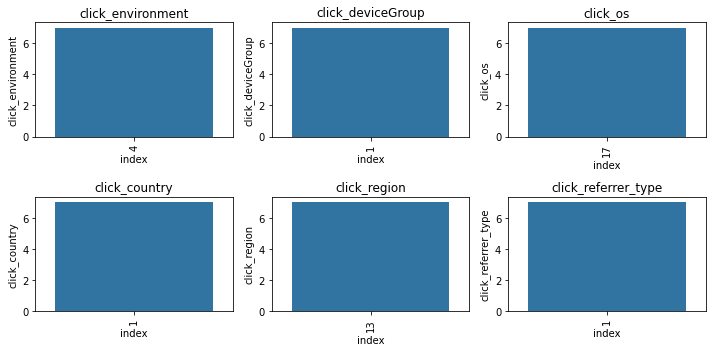

<Figure size 432x288 with 0 Axes>

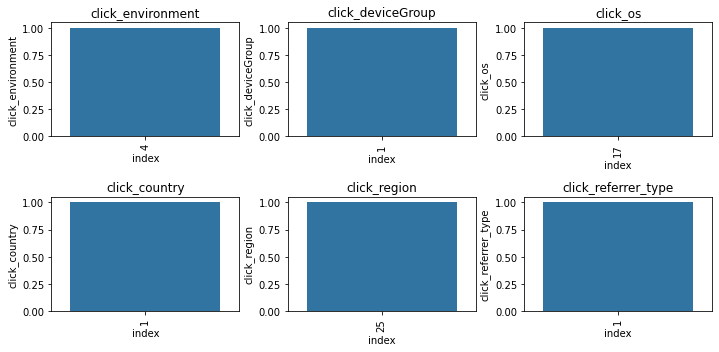

<Figure size 432x288 with 0 Axes>

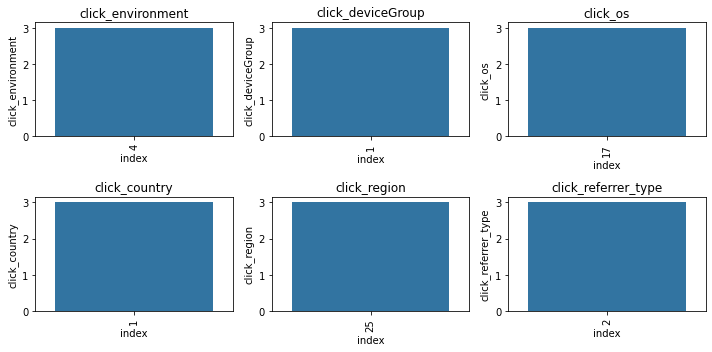

<Figure size 432x288 with 0 Axes>

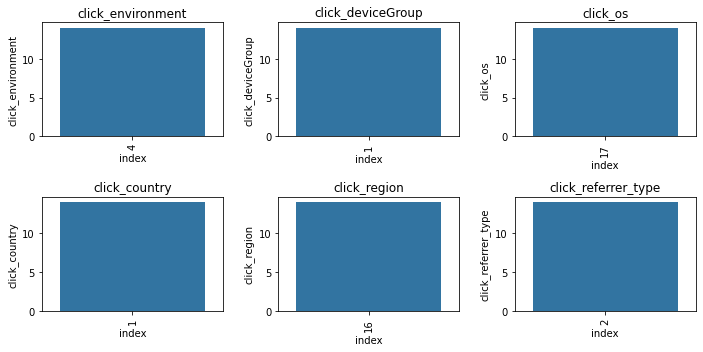

<Figure size 432x288 with 0 Axes>

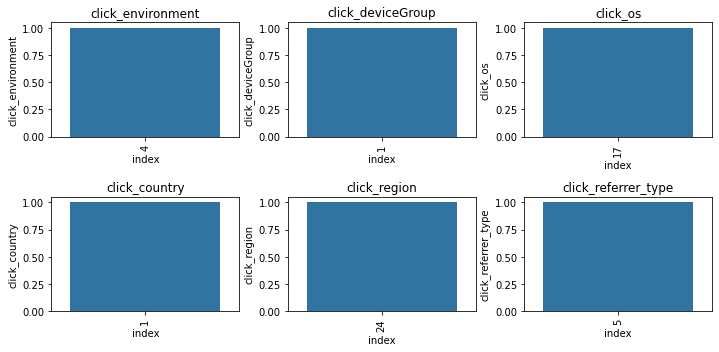

In [34]:
sample_user_ids=np.random.choice(tst_click['user_id'].unique(),size=10,replace=False)
sample_users=user_click_merge[user_click_merge['user_id'].isin(sample_user_ids)]
cols=['click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type']
for _,user_df in sample_users.groupby('user_id'):
    plot_envs(user_df,cols,2,3)

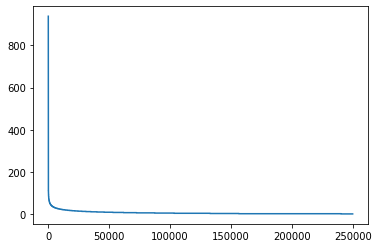

In [35]:
user_click_item_count=sorted(user_click_merge.groupby('user_id')['click_article_id'].count(),reverse=True)
plt.plot(user_click_item_count)

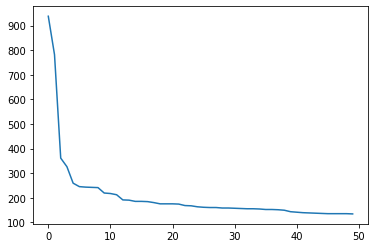

In [36]:
plt.plot(user_click_item_count[:50])

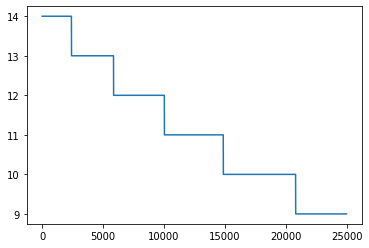

In [37]:
plt.plot(user_click_item_count[25000:50000])

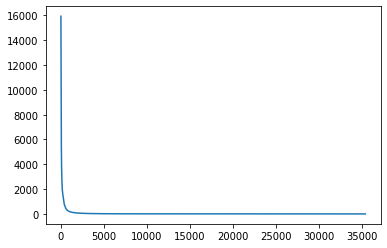

In [38]:
item_click_count=sorted(user_click_merge.groupby('click_article_id')['user_id'].count(),reverse=True)
plt.plot(item_click_count)

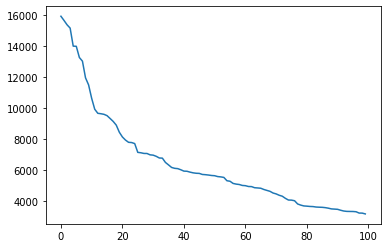

In [39]:
plt.plot(item_click_count[:100])

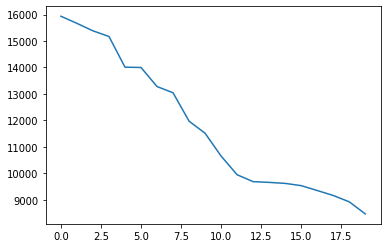

In [40]:
plt.plot(item_click_count[:20])

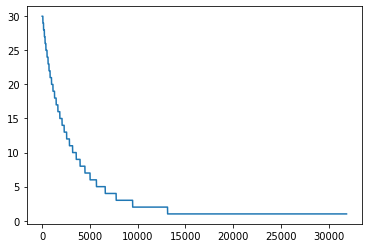

In [41]:
plt.plot(item_click_count[3500:])

In [42]:
tmp=user_click_merge.sort_values('click_timestamp')
tmp['next_item']=tmp.groupby(['user_id'])['click_article_id'].transform(lambda x:x.shift(-1)) # shift():错位
union_item=tmp.groupby(['click_article_id','next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count',ascending=False)
union_item[['count']].describe()

,count
count,433597.000000
mean,3.184139
std,18.851753
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


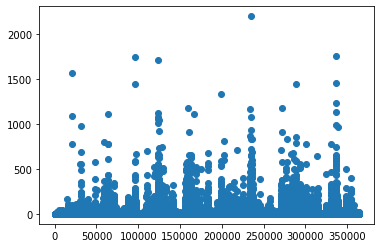

In [43]:
x=union_item['click_article_id']
y=union_item['count']
plt.scatter(x,y)

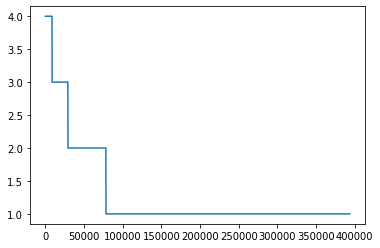

In [44]:
plt.plot(union_item['count'].values[40000:])

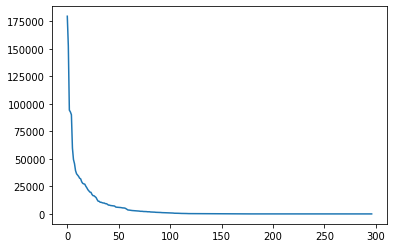

In [45]:
plt.plot(user_click_merge['category_id'].value_counts().values)

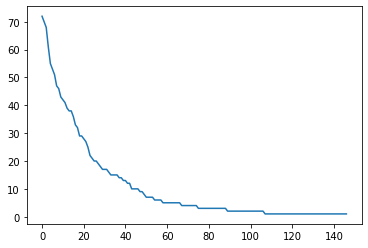

In [46]:
plt.plot(user_click_merge['category_id'].value_counts().values[150:])

In [47]:
user_click_merge['category_id'].value_counts().values[150:] # value_counts()得到的结果就是排好序的

array([72, 70, 68, 61, 55, 53, 51, 47, 46, 43, 42, 41, 39, 38, 38, 36, 33,
       32, 29, 29, 28, 27, 25, 22, 21, 20, 20, 19, 18, 17, 17, 17, 16, 15,
       15, 15, 15, 14, 14, 13, 13, 12, 12, 10, 10, 10, 10,  9,  9,  8,  7,
        7,  7,  7,  6,  6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,
        4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [48]:
user_click_merge['words_count'].describe()

count    1.630633e+06
mean     2.043012e+02
std      6.382198e+01
min      0.000000e+00
25%      1.720000e+02
50%      1.970000e+02
75%      2.290000e+02
max      6.690000e+03
Name: words_count, dtype: float64

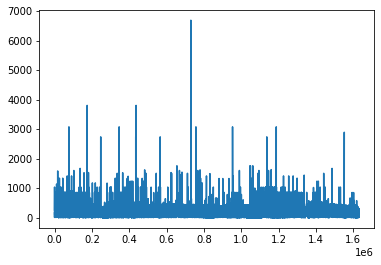

In [49]:
plt.plot(user_click_merge['words_count'].values)

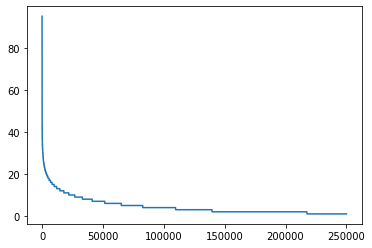

In [50]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(),reverse=True))

In [51]:
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()

,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


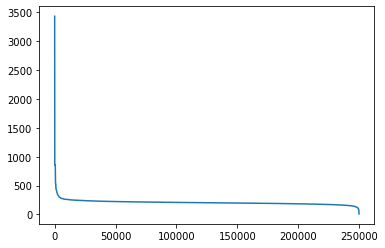

In [52]:
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(),reverse=True)) # mean():平均数

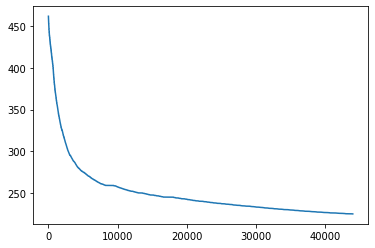

In [53]:
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(),reverse=True)[1000:45000])

In [54]:
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

,user_id,words_count
count,250000.000000,250000.000000
mean,124999.500000,205.830189
std,72168.927986,47.174030
min,0.000000,8.000000
25%,62499.750000,187.500000
50%,124999.500000,202.000000
75%,187499.250000,217.750000
max,249999.000000,3434.500000


In [55]:
from sklearn.preprocessing import MinMaxScaler # 归一化
mm=MinMaxScaler()
user_click_merge['click_timestamp']=mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts']=mm.fit_transform(user_click_merge[['created_at_ts']])

user_click_merge=user_click_merge.sort_values('click_timestamp')

In [56]:
user_click_merge.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
18,249990,162300,0.000000,4,3,20,1,25,2,5,5,281,0.989186,193
2,249998,160974,0.000002,4,1,12,1,13,2,5,5,281,0.989092,259
30,249985,160974,0.000003,4,1,17,1,8,2,8,8,281,0.989092,259
50,249979,162300,0.000004,4,1,17,1,25,2,2,2,281,0.989186,193
25,249988,160974,0.000004,4,1,17,1,21,2,17,17,281,0.989092,259


In [57]:
def mean_diff_time_func(df,col):
    df=pd.DataFrame(df,columns={col})
    df['time_shift1']=df[col].shift(1).fillna(0) # fillna():填充空值
    df['diff_time']=abs(df[col]-df['time_shift1'])
    return df['diff_time'].mean()

In [58]:
mean_diff_click_time=user_click_merge.groupby('user_id')['click_timestamp','created_at_ts'].apply(lambda x:mean_diff_time_func(x,'click_timestamp'))

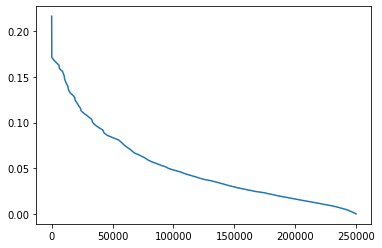

In [59]:
plt.plot(sorted(mean_diff_click_time.values, reverse=True))

In [60]:
mean_diff_created_time=user_click_merge.groupby('user_id')['click_timestamp','created_at_ts'].apply(lambda x: mean_diff_time_func(x,'created_at_ts'))

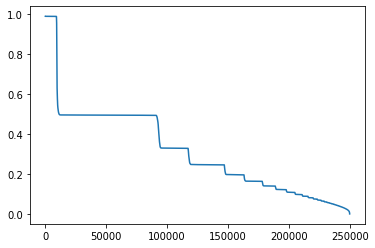

In [61]:
plt.plot(sorted(mean_diff_created_time.values,reverse=True)) # reverse=True:降序

In [66]:
from gensim.models import Word2Vec
import logging, pickle


def trian_item_word2vec(click_df, embed_size=16, save_name='item_w2v_emb.pkl', split_char=' '):
    click_df = click_df.sort_values('click_timestamp')
    click_df['click_article_id'] = click_df['click_article_id'].astype(str)

    docs = click_df.groupby(['user_id'])['click_article_id'].apply(lambda x: list(x)).reset_index()
    docs = docs['click_article_id'].values.tolist()

    logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

    w2v = Word2Vec(docs, size=16, sg=1, window=5, seed=2020, workers=24, min_count=1, iter=10)
    
    item_w2v_emb_dict = {k: w2v[k] for k in click_df['click_article_id']}
    
    return item_w2v_emb_dict

In [69]:
item_w2v_emb_dict = trian_item_word2vec(user_click_merge)

2020-12-14 23:16:17,153:INFO:collecting all words and their counts
2020-12-14 23:16:17,154:INFO:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-14 23:16:17,168:INFO:PROGRESS: at sentence #10000, processed 25727 words, keeping 3473 word types
2020-12-14 23:16:17,183:INFO:PROGRESS: at sentence #20000, processed 53883 words, keeping 5811 word types
2020-12-14 23:16:17,200:INFO:PROGRESS: at sentence #30000, processed 84881 words, keeping 7676 word types
2020-12-14 23:16:17,231:INFO:PROGRESS: at sentence #40000, processed 118390 words, keeping 9297 word types
2020-12-14 23:16:17,252:INFO:PROGRESS: at sentence #50000, processed 154179 words, keeping 10844 word types
2020-12-14 23:16:17,273:INFO:PROGRESS: at sentence #60000, processed 192350 words, keeping 12357 word types
2020-12-14 23:16:17,295:INFO:PROGRESS: at sentence #70000, processed 233685 words, keeping 13473 word types
2020-12-14 23:16:17,334:INFO:PROGRESS: at sentence #80000, processed 281335 words, keepin

In [70]:
sub_user_ids = np.random.choice(user_click_merge.user_id.unique(), size=15, replace=False)
sub_user_info = user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

sub_user_info.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
74931,222092,64329,0.006212,4,3,2,1,24,2,9,9,134,0.989259,199
74932,222092,254489,0.006267,4,3,2,1,24,1,8,9,389,0.989168,185
74933,222092,272143,0.006294,4,3,2,1,24,1,7,9,399,0.989235,184
74934,222092,284622,0.006302,4,3,2,1,24,1,6,9,412,0.989149,212
99867,212871,166581,0.008738,4,3,2,1,12,2,25,25,289,0.989241,210


In [71]:
def get_item_sim_list(df):
    sim_list = []
    item_list = df['click_article_id'].values
    for i in range(0, len(item_list)-1):
        emb1 = item_w2v_emb_dict[str(item_list[i])] # 需要注意的是word2vec训练时候使用的是str类型的数据
        emb2 = item_w2v_emb_dict[str(item_list[i+1])]
        sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2)))) # np.dot():矩阵点乘；np.linalg包含了线性代数的函数方法；norm():求矩阵范数，默认为求特征值，然后求最大特征值得算术平方根
    sim_list.append(0)
    return sim_list

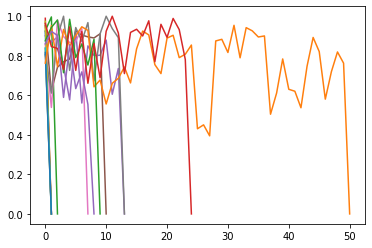

In [72]:
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list = get_item_sim_list(user_df)
    plt.plot(item_sim_list)